In [1]:
import os
import pandas as pd
import numpy as np

## 함수

In [2]:
def train_test_split(data):
    data = data.copy()
    data.drop(['tourney_date', 'winner_id', 'loser_id'], axis=1, inplace=True)
    np.random.seed(2021)
    random_number = np.random.rand(len(data), ) < 0.5
    data_win = data.copy()#[random_number]
    data_lose = data.copy()#[~random_number]
    data_win['y'] = 1
    data_lose['y'] = 0
    trim_data = data_lose.rename(columns={'winner_hand': 'loser_hand', 'loser_hand': 'winner_hand',
                                          'winner_ht': 'loser_ht', 'loser_ht': 'winner_ht',
                                          'winner_age': 'loser_age', 'loser_age': 'winner_age',
                                          'winner_rank': 'loser_rank', 'loser_rank': 'winner_rank',
                                          'winner_rank_points': 'loser_rank_points', 'loser_rank_points': 'winner_rank_points',
                                         })
    trim_data = pd.concat([trim_data, data_win])
    # more trimming
    trim_data['ht_dff'] = trim_data['winner_ht'] - trim_data['loser_ht']
    trim_data['rank_points_dff'] = trim_data['winner_rank_points'] - trim_data['loser_rank_points']
    trim_data['age_dff'] = trim_data['winner_age'] - trim_data['loser_age']
    
    trim_data.drop(['winner_ht', 'loser_ht', 'winner_rank_points', 'loser_rank_points', 'winner_age', 'loser_age'], axis=1, inplace=True)
    
    trim_data.rename(columns={'winner_hand': 'hand',
                              'loser_hand': 'opponent_hand',
                              'winner_rank': 'rank',
                              'loser_rank': 'opponent_rank'}, inplace=True)
    # encoding
    trim_data.loc[(trim_data.surface == 'Carpet'),'surface'] = np.nan
    final_data = pd.get_dummies(trim_data, columns=["hand",'opponent_hand', 'best_of', 'surface'])
    final_data.dropna(inplace=True)
    # split
    print(final_data.shape)
    X = final_data.drop(["Quarter", 'y', 'Month'], axis=1)
    print(X.columns)
    y = final_data['y']
    return X, y

# 데이터 전처리

In [3]:
file_list = os.listdir()
file_list

['.git',
 '.ipynb_checkpoints',
 '2001-2018 (1).csv',
 '2019.csv',
 '2020.csv',
 'ATP EDA.ipynb',
 'catboost_info',
 'model.ipynb',
 'README.md']

In [4]:
train_data = pd.read_csv(file_list[2], index_col=0)
test_data19 = pd.read_csv(file_list[3], index_col=0)
test_data20 = pd.read_csv(file_list[4], index_col=0)

In [5]:
train_data.isna().sum()

surface                198
tourney_date             0
winner_id                0
winner_hand             17
winner_ht             4036
winner_age               6
loser_id                 0
loser_hand              43
loser_ht              6647
loser_age               17
best_of                  0
winner_rank            459
winner_rank_points     459
loser_rank            1174
loser_rank_points     1174
Month                    0
Quarter                  0
dtype: int64

In [6]:
X_train, y_train = train_test_split(train_data)
X_test19, y_test19 = train_test_split(test_data19)
X_test20, y_test20 = train_test_split(test_data20)

(93886, 19)
Index(['opponent_rank', 'rank', 'ht_dff', 'rank_points_dff', 'age_dff',
       'hand_L', 'hand_R', 'hand_U', 'opponent_hand_L', 'opponent_hand_R',
       'opponent_hand_U', 'best_of_3', 'best_of_5', 'surface_Clay',
       'surface_Grass', 'surface_Hard'],
      dtype='object')
(1682, 19)
Index(['opponent_rank', 'rank', 'ht_dff', 'rank_points_dff', 'age_dff',
       'hand_L', 'hand_R', 'hand_U', 'opponent_hand_L', 'opponent_hand_R',
       'opponent_hand_U', 'best_of_3', 'best_of_5', 'surface_Clay',
       'surface_Grass', 'surface_Hard'],
      dtype='object')
(544, 19)
Index(['opponent_rank', 'rank', 'ht_dff', 'rank_points_dff', 'age_dff',
       'hand_L', 'hand_R', 'hand_U', 'opponent_hand_L', 'opponent_hand_R',
       'opponent_hand_U', 'best_of_3', 'best_of_5', 'surface_Clay',
       'surface_Grass', 'surface_Hard'],
      dtype='object')


# 모델링

In [7]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix

## 나이브 베이즈

In [8]:
from sklearn.naive_bayes import GaussianNB

In [9]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred19 = gnb.predict(X_test19)
y_pred20 = gnb.predict(X_test20)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test19 != y_pred19).sum()))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test20 != y_pred20).sum()))

Number of mislabeled points out of a total 1682 points : 618
Number of mislabeled points out of a total 1682 points : 166


In [10]:
print(2019)
report = classification_report(y_test19,y_pred19)
print(report)
print('     ')
print(2020)
report = classification_report(y_test20,y_pred20)
print(report)

2019
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       841
           1       0.63      0.63      0.63       841

    accuracy                           0.63      1682
   macro avg       0.63      0.63      0.63      1682
weighted avg       0.63      0.63      0.63      1682

     
2020
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       272
           1       0.69      0.69      0.69       272

    accuracy                           0.69       544
   macro avg       0.69      0.69      0.69       544
weighted avg       0.69      0.69      0.69       544



In [11]:
gnb.predict_proba(X_test19)

array([[0.67563787, 0.32436213],
       [0.59758447, 0.40241553],
       [0.43383242, 0.56616758],
       ...,
       [0.53196846, 0.46803154],
       [0.41764888, 0.58235112],
       [0.60140039, 0.39859961]])

## 로지스틱

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logistic_model = LogisticRegression(random_state=2020)

In [14]:
logistic = LogisticRegression(random_state=2020)
logistic.fit(X_train, y_train)
y_pred19 = logistic.predict(X_test19)
y_pred20 = logistic.predict(X_test20)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test19 != y_pred19).sum()))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test20 != y_pred20).sum()))

Number of mislabeled points out of a total 1682 points : 604
Number of mislabeled points out of a total 1682 points : 162


In [15]:
print(2019)
report = classification_report(y_test19,y_pred19)
print(report)
print('     ')
print(2020)
report = classification_report(y_test20,y_pred20)
print(report)

2019
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       841
           1       0.64      0.64      0.64       841

    accuracy                           0.64      1682
   macro avg       0.64      0.64      0.64      1682
weighted avg       0.64      0.64      0.64      1682

     
2020
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       272
           1       0.70      0.70      0.70       272

    accuracy                           0.70       544
   macro avg       0.70      0.70      0.70       544
weighted avg       0.70      0.70      0.70       544



In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

logistic_2 = LogisticRegression(random_state=2020)
logistic_2.fit(scaler.transform(X_train), y_train)
y_pred19 = logistic_2.predict(scaler.transform(X_test19))
y_pred20 = logistic_2.predict(scaler.transform(X_test20))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test19 != y_pred19).sum()))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test20 != y_pred20).sum()))

Number of mislabeled points out of a total 1682 points : 604
Number of mislabeled points out of a total 1682 points : 162


In [17]:
logistic.predict_proba(X_test19)

array([[0.7311899 , 0.2688101 ],
       [0.63589759, 0.36410241],
       [0.43510821, 0.56489179],
       ...,
       [0.53915035, 0.46084965],
       [0.43758928, 0.56241072],
       [0.59215929, 0.40784071]])

## xgboost

In [18]:
from xgboost import XGBClassifier, plot_importance

In [19]:
# xgb_rg = XGBClassifier()
#
# xgb_params = {
#     'n_estimators': [200, 400, 600],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_child_weight': [1, 2],
#     'gamma': [0.5, 1, 1.5, 2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'max_depth': [3, 5]
# }
# 
# grid_xgb = GridSearchCV(xgb_rg, param_grid=xgb_params,
#                         cv=5, scoring='f1')
# 
# evals = [(X_test19, y_test19)]
# grid_xgb.fit(X_train, y_train, eval_set=evals)
# grid_xgb.best_estimator_

In [20]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier()

In [21]:
y_pred19 = xgb.predict(X_test19)
y_pred20 = xgb.predict(X_test20)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test19 != y_pred19).sum()))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test20 != y_pred20).sum()))

Number of mislabeled points out of a total 1682 points : 621
Number of mislabeled points out of a total 1682 points : 171


In [22]:
print(2019)
report = classification_report(y_test19,y_pred19)
print(report)
print('     ')
print(2020)
report = classification_report(y_test20,y_pred20)
print(report)

2019
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       841
           1       0.63      0.63      0.63       841

    accuracy                           0.63      1682
   macro avg       0.63      0.63      0.63      1682
weighted avg       0.63      0.63      0.63      1682

     
2020
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       272
           1       0.69      0.68      0.69       272

    accuracy                           0.69       544
   macro avg       0.69      0.69      0.69       544
weighted avg       0.69      0.69      0.69       544



In [23]:
xgb.predict_proba(X_test19)

array([[0.71163714, 0.28836283],
       [0.6743979 , 0.3256021 ],
       [0.4212224 , 0.5787776 ],
       ...,
       [0.5642036 , 0.43579638],
       [0.40721112, 0.5927889 ],
       [0.6274625 , 0.37253752]], dtype=float32)

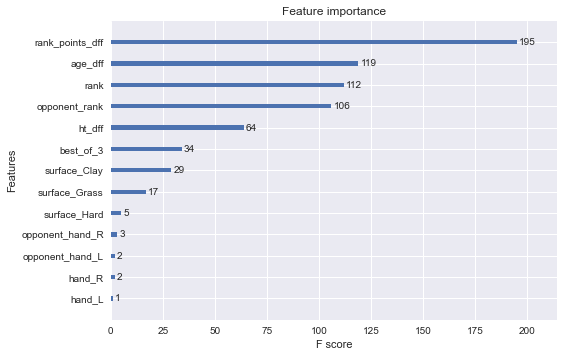

In [24]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plot_importance(xgb)
plt.show()

## catboost

In [25]:
from catboost import CatBoostClassifier

In [26]:
catboost = CatBoostClassifier(n_estimators = 1000, learning_rate =0.05, verbose=False)
catboost.fit(X_train, y_train)

In [27]:
y_pred19 = catboost.predict(X_test19)
y_pred20 = catboost.predict(X_test20)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test19 != y_pred19).sum()))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test19.shape[0], (y_test20 != y_pred20).sum()))

Number of mislabeled points out of a total 1682 points : 598
Number of mislabeled points out of a total 1682 points : 163


In [28]:
print(2019)
report = classification_report(y_test19,y_pred19)
print(report)
print('     ')
print(2020)
report = classification_report(y_test20,y_pred20)
print(report)

2019
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       841
           1       0.64      0.65      0.65       841

    accuracy                           0.64      1682
   macro avg       0.64      0.64      0.64      1682
weighted avg       0.64      0.64      0.64      1682

     
2020
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       272
           1       0.70      0.70      0.70       272

    accuracy                           0.70       544
   macro avg       0.70      0.70      0.70       544
weighted avg       0.70      0.70      0.70       544



In [29]:
catboost.predict_proba(X_test19)

array([[0.70022347, 0.29977653],
       [0.64566558, 0.35433442],
       [0.4354065 , 0.5645935 ],
       ...,
       [0.56305409, 0.43694591],
       [0.42156276, 0.57843724],
       [0.60548164, 0.39451836]])